In [1]:
"""
EMRE GİRGİN
2021700060
"""

'\nEMRE GİRGİN\n2021700060\n'

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

table_shape = (4,6,4,6,2)
epsilon_decay = 0.99997
gamma = 0.999
lr = 0.1
num_episodes = 3500

In [3]:
def quantize(observation):
    """
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

    0th range = -2.4 , 2.4
    1st range = -2.5, 2.5
    2nd range = -0.21, 0.21
    3rd range = -3.0 , 3.0

    :param observation:
    :return:
    """
    global table_shape

    quantized = [0, 0, 0, 0]

    boundaries = [
                  np.linspace(-2.4, 2.4, table_shape[0]-1),
                  np.linspace(-2.5, 2.5, table_shape[1]-1),
                  np.linspace(-0.2095, 0.2095, table_shape[2]-1),
                  np.linspace(-3.0, 3.0, table_shape[3]-1),
    ]


    for i in range(len(observation)):
        quantized[i] = np.digitize(observation[i], boundaries[i])


    return np.asarray(quantized)

def epsilon_greedy(s, Q, e=0.1):
    if np.random.uniform() < e:
        return np.random.choice([0, 1])
    else:
        return np.argmax(Q[tuple(s)])


def bellman_eqn(s, a, r, s_next, Q, gamma=0.999, lr=0.25, done=False):

    if done:
        Q[s[0], s[1], s[2], s[3], a] +=  lr * (r + gamma * 0 - Q[s[0], s[1], s[2], s[3], a])
    else:
        Q[s[0], s[1], s[2], s[3], a] +=  lr * (r + gamma * Q[s_next[0], s_next[1], s_next[2], s_next[3]].max() - Q[s[0], s[1], s[2], s[3], a])

    return Q



In [4]:
def run():
    e = 1.0

    global table_shape
    
    reward_history = []

    Q_table = np.zeros(table_shape)
    
    env = gym.make('CartPole-v0')
    for i_episode in range(num_episodes):
        observation = env.reset()
        cum_reward = 0
        for t in range(1000):
            # env.render()
            quantized = quantize(observation)
            e *= epsilon_decay
            
            action = epsilon_greedy(s=quantized, Q=Q_table, e=e)
            observation, reward, done, info = env.step(action)

            if done:
                Q_table = bellman_eqn(quantized, action, reward, quantize(observation), Q_table, gamma=gamma, lr=lr, done=True)
                reward_history.append(cum_reward)
                break
            else:
                cum_reward += reward
                Q_table = bellman_eqn(quantized, action, reward, quantize(observation), Q_table, gamma=gamma, lr=lr, done=False)
    env.close()

    return reward_history

def moving_average(a, n=3) :
    """
    from:
    https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

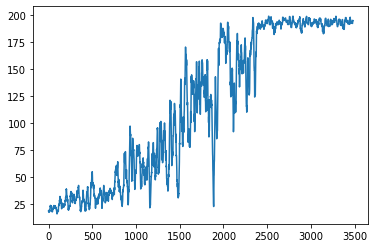

In [5]:
reward_hist = run()
plt.plot(moving_average(reward_hist, 20))
plt.show()